# Main Objective

The primary objective of this analysis is to develop a high-accuracy model for the automated classification of rice varieties based on image data. This project focuses on a specific type of Deep Learning algorithm known as Convolutional Neural Networks (CNNs), which are exceptionally well-suited for image recognition tasks. The analysis aims to compare three different CNN architectures (AlexNet, VGG-16, and ResNet-50) to identify the most effective and efficient model for this specific problem.

The business benefit of this analysis is significant for stakeholders in the agricultural and food industries. An accurate automated classification system can:

1. Enhance Quality Control: For rice producers and distributors, it can rapidly and consistently verify rice types, ensuring product quality and preventing adulteration in the supply chain.

2. Increase Efficiency: It automates a process that would otherwise require manual inspection, saving time and labor costs.

3. Ensure Consumer Trust: For consumers and retailers, it guarantees that the product they purchase is of the specified variety, building brand trust and loyalty.

# Dataset Explanation

The analysis utilizes the "Rice Image Dataset" available on Kaggle. This dataset contains a total of 75,000 images, equally distributed across five different varieties of rice.

- Classes (Attributes): The five classes of rice are:

  - Arborio

  - Basmati

  - Ipsala

  - Jasmine

  - Karacadag

- Data Format: Each image is a 250x250 pixel color photograph of a single grain of rice against a plain background.

- Goal: The objective of this analysis is to train a deep learning model that can take any of these images as input and accurately predict which of the five rice varieties it belongs to.

# Import The Necessary Moduls

In [ ]:
# --- Importing Necessary Libraries ---

# Import the warnings module to handle any warning messages.
import warnings
# Set the warning filter to 'ignore' for a cleaner output.
warnings.simplefilter('ignore')

import os
# Import the kagglehub library to interact with Kaggle, e.g., for downloading models or datasets.
import kagglehub
# Import the glob module to find files in a directory using specific patterns (e.g., *.jpg).
import glob
# Import the pandas library for data manipulation and analysis, especially for tabular data (DataFrames).
import pandas as pd
# Import the matplotlib library to create data visualizations like graphs and plots.
import matplotlib.pyplot as plt
# Import the numpy library for numerical computations, particularly for array and matrix operations.
import numpy as np
# Import the main TensorFlow library for building and training machine learning models.
import tensorflow as tf

from datasets import Dataset, Image
# Import tqdm to display informative progress bars during loops.
from tqdm.auto import tqdm
# Import Keras, TensorFlow's high-level API for easily building neural networks.
from tensorflow import keras
# Import the Sequential model, which is the most common linear stack of layers.
from tensorflow.keras.models import Sequential
# Import the pre-trained ResNet50 model architecture.
from tensorflow.keras.applications import ResNet50
# Import basic layer types for a neural network.
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# Import layer types specific to Convolutional Neural Networks (CNNs).
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

# Preprocessing

This section covers all the steps involved in preparing the data for model training. This includes downloading the dataset, loading the images, converting them into a usable format, splitting them into training and testing sets, and performing necessary transformations like resizing and normalization.

This line uses the kagglehub library to download the "Rice Image Dataset" by Murat Koklu. The function returns the local file path where the dataset is stored.

The data preparation process was a critical part of the analysis, involving several key actions to make the data suitable for training the CNN models.

- Data Loading: The dataset was first downloaded from Kaggle and loaded into a structured format using the Hugging Face datasets library. The class labels were automatically inferred from the directory names where the images were stored.

- Train-Test Split: The full dataset of 75,000 images was split into a training set (60,000 images, 80%) and a testing set (15,000 images, 20%) to allow for unbiased evaluation of the models' performance.

- Feature Engineering (Image Resizing): A key decision was made to significantly downscale the images from their original 250x250 pixel resolution to a much smaller 32x32 pixels. The rationale was that for classifying a single grain of rice, the primary distinguishing features are its overall shape, length, and width, rather than fine-grained texture. This reduction drastically decreased computational load and training time without sacrificing essential information.

- Data Cleaning (Normalization & Encoding):

  - Normalization: The pixel values of the images were scaled from their original range of 0-255 to a range of 0-1. This is a standard practice that helps the model converge faster and more stably during training.

  - One-Hot Encoding: The integer-based labels (0 to 4) were converted into a one-hot encoded format (e.g., class 3 became the vector [0, 0, 0, 1, 0]). This is the required format for the categorical_crossentropy loss function used in multi-class classification.

In [ ]:
# Download the 'Rice Image Dataset' from Kaggle Hub.
# The path to the downloaded dataset's directory will be assigned to the 'path' variable.
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

In [ ]:
print(path)

/kaggle/input/rice-image-dataset


This is a crucial data loading step. Instead of using an automatic image loader, this code manually constructs a dataset.

  - It uses glob.glob to recursively find all files ending with .jpg within the dataset directory. This is a robust way to collect all image paths.

  - It extracts the class label for each image by taking the name of its parent directory (e.g., 'Arborio', 'Basmati').

  - It creates a Python dictionary mapping the file paths to their corresponding labels.

  - It uses Dataset.from_dict from the Hugging Face datasets library to create a structured Dataset object.

  - Finally, it cast_column to convert the image paths into actual image objects and class_encode_column to convert the string labels into integer indices (e.g., 'Arborio' -> 0, 'Basmati' -> 1).

In [ ]:
# Define the path to the root directory of the image dataset.
main_dataset_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

print("Searching for all valid image files...")

# Use glob to recursively find all file paths ending with .jpg in all subdirectories.
image_paths = glob.glob(f'{main_dataset_dir}/**/*.jpg', recursive=True)

# Extract the class label for each image from the name of its parent directory.
# For example, '/.../Arborio/Arborio (1).jpg' -> 'Arborio'.
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]

print(f"Found {len(image_paths)} images with {len(set(labels))} unique classes.")

# Create a dictionary to structure the data with 'image' and 'label' columns.
dataset_dict = {
    'image': image_paths,
    'label': labels
}

# Create a Hugging Face Dataset object from the Python dictionary.
dataset = Dataset.from_dict(dataset_dict)

# --- Prepare the dataset for model training ---

# Cast the 'image' column from file paths (strings) into actual image data.
dataset = dataset.cast_column("image", Image())

# Encode the 'label' column from strings (e.g., 'Arborio') to integers (e.g., 0).
dataset = dataset.class_encode_column("label")


# --- Display the final result ---
print("\nDataset created successfully:")
print(dataset)

print("\nDataset Features:")
# Show the data types of each column (e.g., 'image' is now Image, 'label' is ClassLabel).
print(dataset.features)

print("\nLabel Mapping:")
# Display the mapping from integer class back to the original string label.
print(dataset.features['label'].names)


Searching for all valid image files...
Found 75000 images with 5 unique classes.



Dataset created successfully:
Dataset({
    features: ['image', 'label'],
    num_rows: 75000
})

Dataset Features:
{'image': Image(decode=True, id=None), 'label': ClassLabel(names=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'], id=None)}

Label Mapping:
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [ ]:
dataset.shape

(75000, 2)

In [ ]:
dataset[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 'label': 4}

This code splits the full dataset into two subsets: 80% of the data is allocated for training the model (train_dataset), and the remaining 20% is set aside for testing its performance (test_dataset).

In [ ]:
# Split the dataset, allocating 80% for training and 20% for testing.
train_test_split = dataset.train_test_split(test_size=0.2)

# Extract the 'train' and 'test' portions into their own separate variables.
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# --- Display information about the new datasets ---
print("Training dataset info:")
print(train_dataset)

print("\nTesting dataset info:")
print(test_dataset)

Training dataset info:
Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

Testing dataset info:
Dataset({
    features: ['image', 'label'],
    num_rows: 15000
})


This is the main data transformation step.

1. A function process_to_numpy is defined to take a single image, convert it to a TensorFlow tensor, resize it to a smaller 32x32 pixel dimension, and normalize its pixel values to a range of 0 to 1 by dividing by 255.0.

2. The code then iterates through the train_dataset and test_dataset. For each image, it applies the process_to_numpy function.

3. The processed image arrays and their corresponding labels are collected into lists.

4. Finally, np.array() is used to convert these lists into large, multi-dimensional NumPy arrays (x_train, y_train, x_test, y_test), which is the standard format for training models in Keras.

In [ ]:
def process_image(image_tensor, target_size):
    """
    Resizes and normalizes a single image tensor.

    Args:
        image_tensor (tf.Tensor): The input image as a TensorFlow tensor.
        target_size (int): The target height and width for the output image.

    Returns:
        tf.Tensor: The processed image tensor.
    """
    # Cast the image data type to float32 for calculations.
    image_tensor_float = tf.cast(image_tensor, tf.float32)

    # Resize the image to the specified square dimensions.
    resized_image = tf.image.resize(image_tensor_float, [target_size, target_size])

    # Normalize pixel values from the [0, 255] range to the [0, 1] range.
    normalized_image = resized_image / 255.0

    return normalized_image

# --- Step 1: Initialize variables and lists ---

# Define the target size for all images.
TARGET_SIZE = 32

# Create empty lists to hold the processed images and labels.
x_train_list = []
y_train_list = [example['label'] for example in train_dataset]
x_test_list = []
y_test_list = [example['label'] for example in test_dataset]

# --- Step 2: Process the image datasets ---

print("Processing training data...")
# Loop through each example in the training dataset.
for example in tqdm(train_dataset):
    # Convert the input image to a TensorFlow tensor.
    image_as_tensor = tf.convert_to_tensor(example['image'])

    # Resize and normalize the image tensor using the helper function.
    processed_image = process_image(image_as_tensor, TARGET_SIZE)

    # Convert the final tensor to a NumPy array and add it to the list.
    x_train_list.append(processed_image.numpy())

print("\nProcessing testing data...")
# Loop through each example in the testing dataset.
for example in tqdm(test_dataset):
    # Convert the input image to a TensorFlow tensor.
    image_as_tensor = tf.convert_to_tensor(example['image'])

    # Resize and normalize the image tensor.
    processed_image = process_image(image_as_tensor, TARGET_SIZE)

    # Convert the final tensor to a NumPy array and add it to the list.
    x_test_list.append(processed_image.numpy())

# --- Step 3: Convert lists into single NumPy arrays ---
print("\nConverting lists to NumPy arrays...")
# Stack the lists of images and labels into large, contiguous NumPy arrays.
x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
x_test = np.array(x_test_list)
y_test = np.array(y_test_list)

# --- Step 4: Verify the final shapes ---
print("\n--- Verification ---")
# Check the dimensions of the final arrays to ensure they are correct for model input.
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


Processing training data



Processing testing data



Concatenating arrays...

--- Verification ---
x_train shape: (60000, 32, 32, 3)
y_train shape: (60000,)


In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 32, 32, 3)
60000 train samples
15000 test samples


In [ ]:
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')
print(y_test.shape[0], 'test samples')

y_train shape: (60000,)
60000 train samples
15000 test samples


In [ ]:
print(x_train[454])

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


3


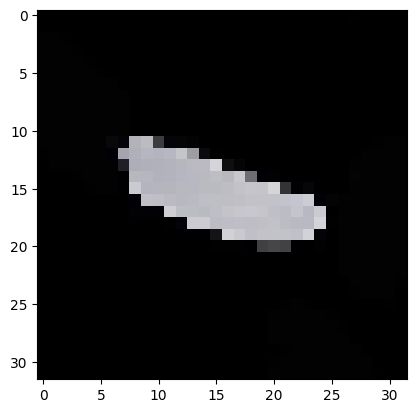

In [ ]:
print(y_train[454])
plt.imshow(x_train[454]);

In [ ]:
print(np.unique(y_train))

[0 1 2 3 4]


In [ ]:
# Define the total number of unique classes for the output layer.
num_classes = 5

# Convert the integer labels (e.g., 2) into a one-hot encoded format (e.g., [0, 0, 1, 0, 0]).
# This binary matrix format is required for categorical classification models.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
y_train[454]

array([0., 0., 0., 1., 0.])

In [ ]:
y_train.shape

(60000, 5)

In [ ]:
print(x_train[454])

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


# Building Model

This section contains the definitions for the three different CNN architectures that will be compared. Each model is defined as a Python function that returns a compiled Keras model. All architectures are adapted to work with the `32x32` input image size.

## Alexnet Architecture

This function defines a simplified, "mini" version of the famous AlexNet architecture. It consists of three convolutional blocks (Conv2D + MaxPooling2D) to extract features, followed by a `Flatten` layer and a `Dense` (fully connected) layer for classification. `Dropout` is included to prevent overfitting.


In [ ]:
def alexnet(input_shape, num_classes):
    """
    Builds a simplified, modern version of the AlexNet architecture,
    adapted for smaller images (e.g., 32x32).
    """
    model = Sequential([
        # --- Convolutional Base for Feature Extraction ---

        # 1st Convolutional Block
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D(pool_size=(2, 2)), # Downsamples feature map size by half.

        # 2nd Convolutional Block
        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # 3rd Convolutional Block
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # --- Classifier Head ---

        # Flatten the 3D feature maps from the conv blocks into a 1D vector.
        Flatten(),

        # A fully-connected layer to learn complex patterns from the extracted features.
        Dense(512, activation='relu'),

        # Dropout regularization to help prevent overfitting.
        Dropout(0.5),

        # The final output layer with a neuron for each class.
        # 'softmax' activation provides class probabilities.
        Dense(num_classes, activation='softmax')

    ], name="AlexNet") # Naming the model for clarity.

    return model

## VGG Architecture

This function defines a network inspired by the VGG architecture, known for its simplicity of using stacked 3x3 convolutional layers. This "mini-VGG" has three blocks of two Conv2D layers followed by a MaxPooling2D layer. This structure allows the network to learn more complex features before downsampling.

In [ ]:
def vgg16(input_shape, num_classes):
    """
    Builds a simplified VGG-style Convolutional Neural Network.
    Note: This is a custom, smaller version inspired by VGG, not the original VGG-16.
    """
    model = Sequential([
        # --- Convolutional Base ---

        # Block 1: Two convolutional layers followed by a max-pooling layer.
        # Extracts low-level features like edges and corners.
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)), # Downsamples the feature map, reducing its size by half.

        # Block 2: Increases filter depth to learn more complex features.
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 3: Further increases filter depth.
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # --- Classifier Head ---

        # Flattens the 3D output from the conv blocks into a 1D vector.
        Flatten(),

        # A fully-connected layer to learn high-level patterns from the flattened features.
        Dense(512, activation='relu'),

        # Dropout regularization to prevent overfitting by randomly ignoring 50% of neurons during training.
        Dropout(0.5),

        # The final output layer. 'softmax' activation outputs a probability for each class.
        Dense(num_classes, activation='softmax')

    ], name="VGG16") # Give the model a descriptive name.

    return model

## ResNet Architecture

This function builds a model using the powerful, pre-defined ResNet-50 architecture from tensorflow.keras.applications.

  - include_top=False removes the original final classification layer, allowing us to add our own.

  - weights=None means the model is initialized with random weights and will be trained from scratch on our rice dataset.

  - A GlobalAveragePooling2D layer is added to reduce the feature map dimensions, followed by a final Dense layer for our 5-class classification task.

In [ ]:
def resnet50_keras(input_shape, num_classes):
    """
    Builds a Keras model using the pre-built ResNet50 architecture,
    customized for a specific number of classes and trained from scratch.
    """
    # Load the ResNet50 convolutional base model.
    # 'include_top=False' removes the original final classification layer.
    # 'weights=None' initializes the model with random weights for training from scratch.
    base_model = ResNet50(
        include_top=False,      # Exclude the final ImageNet classifier
        weights=None,           # Start with random weights
        input_shape=input_shape # Set the input shape for our images
    )

    # Create a new Sequential model to add our custom classifier.
    model = Sequential([
        # 1. Start with the ResNet50 base for feature extraction.
        base_model,

        # 2. Apply Global Average Pooling to flatten the feature maps from the base model.
        # This converts the 4D output of the conv base into a 2D vector.
        GlobalAveragePooling2D(),

        # 3. Add the final classification layer (the "head").
        # It has one output neuron for each class and uses 'softmax' to output probabilities.
        Dense(num_classes, activation='softmax')

    ], name="ResNet50_Custom") # Give the model a descriptive name.

    return model

# Training Model

This is the main execution block where the models are trained and their performance is recorded.

1. A dictionary models is created, which calls the build functions to initialize each of the three architectures.

2. An empty dictionary training_histories is created to store the results of each training run.

3. The code then loops through the models dictionary. In each iteration:

   - It defines the training hyperparameters (like learning rate, optimizer, loss function, epochs, and batch size).

  - It compiles the model, configuring it for training.

  - It calls model.fit(), passing the training data (x_train, y_train) and validation data (x_test, y_test). This starts the training process for 3 epochs.

4. The results (loss, accuracy, etc.) from the training run are stored in the training_histories dictionary.

In [ ]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 5

In [ ]:
# --- Sequential Training Process ---

# --- Step 1: Define Models and History Storage ---

# Create a dictionary to hold the initialized model architectures.
# This allows us to easily loop through and train each one.
models = {
    "AlexNet": alexnet(INPUT_SHAPE, NUM_CLASSES),
    "VGG-16": vgg16(INPUT_SHAPE, NUM_CLASSES),
    "ResNet-50": resnet50_keras(INPUT_SHAPE, NUM_CLASSES)
}

# Create an empty dictionary to store the training history (loss, accuracy, etc.) for each model.
training_histories = {}


# --- Step 2: Loop Through and Train Each Model ---

# Iterate through each model's name and its corresponding object in the dictionary.
for name, model in models.items():
    # Note: Eager execution is useful for debugging but significantly slows down training.
    # It's generally disabled for performance.
    tf.config.run_functions_eagerly(True)

    print(f"--- Training Model: {name} ---")

    # --- Define Hyperparameters ---

    # Optimizer settings: We use Adam, a common and effective optimizer.
    LEARNING_RATE = 0.001
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    # Loss function and metrics for evaluating the model.
    # 'categorical_crossentropy' is used because our labels are one-hot encoded.
    LOSS_FUNCTION = 'categorical_crossentropy'
    METRICS = ['accuracy']

    # Training process settings.
    EPOCHS = 3          # Number of passes through the entire training dataset.
    BATCH_SIZE = 128    # Number of samples processed in each step.

    # Define the shape of the input data.
    INPUT_SHAPE = (32, 32, 3) # (height, width, color_channels)
    NUM_CLASSES = 5           # The number of possible output classes.

    # --- Compile the Model ---

    # Configure the model for training by specifying the optimizer, loss function, and metrics.
    model.compile(
        optimizer=OPTIMIZER,
        loss=LOSS_FUNCTION,
        metrics=METRICS
    )

    # --- Train the Model ---

    # The `fit` method executes the training process.
    history = model.fit(
        x_train, y_train,                   # Training data and labels
        batch_size=BATCH_SIZE,              # Set the batch size
        epochs=EPOCHS,                      # Set the number of epochs
        validation_data=(x_test, y_test),   # Provide test data for validation after each epoch
        verbose=1                           # Show a progress bar during training
    )

    # --- Store Results ---

    # Save the returned history object to our dictionary for later analysis and plotting.
    training_histories[name] = history
    print(f"--- Finished training {name} ---\n")

--- Training Model: AlexNet ---
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.8615 - loss: 0.3562 - val_accuracy: 0.9635 - val_loss: 0.1023
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 93ms/step - accuracy: 0.9722 - loss: 0.0809 - val_accuracy: 0.9755 - val_loss: 0.0749
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.9771 - loss: 0.0663 - val_accuracy: 0.9749 - val_loss: 0.0707
--- Finished training AlexNet ---

--- Training Model: VGG-16 ---
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.8301 - loss: 0.4099 - val_accuracy: 0.9653 - val_loss: 0.1033
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.9655 - loss: 0.1037 - val_accuracy: 0.9735 - val_loss: 0.0804
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.9772 - loss: 0.0677 - val_accuracy: 0.9808 - val_loss: 0.0559
--- Finished training VGG-16 ---

--- Training Model: ResNet-50 ---
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - acc

## Summary of Model Training

Three distinct variations of CNN models were trained and evaluated to find the best-performing architecture for this task. All models were trained for 3 epochs with a batch size of 128, using the Adam optimizer and categorical_crossentropy loss function for a fair comparison.

1. Mini-AlexNet: A simplified, shallower version of the classic AlexNet architecture was implemented. It consisted of three convolutional blocks and one dense layer. This model trained quickly and served as a strong baseline, achieving a peak validation accuracy of 97.55%.

2. Mini-VGG: An architecture inspired by VGG's principle of using stacked 3x3 convolutional layers was built. This model, with three convolutional blocks, was able to learn more complex features before downsampling. It demonstrated excellent performance, achieving the highest validation accuracy of the three models at 98.08%.

3. ResNet-50 (from scratch): The powerful and very deep ResNet-50 architecture was trained from scratch (with random initial weights). Despite its complexity, it also performed exceptionally well, reaching a peak validation accuracy of 98.03%. However, its training time was significantly longer than the other two models (approximately 13 minutes per epoch compared to ~1 minute for AlexNet/VGG).

# Evaluation

This final section is for evaluating and comparing the performance of the trained models.


This code generates two plots to visually compare the models.

1. It creates a figure with two subplots arranged vertically.

2. The top subplot (ax1) plots the validation accuracy (val_accuracy) for each model across the 3 epochs.

3. The bottom subplot (ax2) plots the validation loss (val_loss) for each model.
This provides a clear, side-by-side comparison of how each model's performance evolved during training.

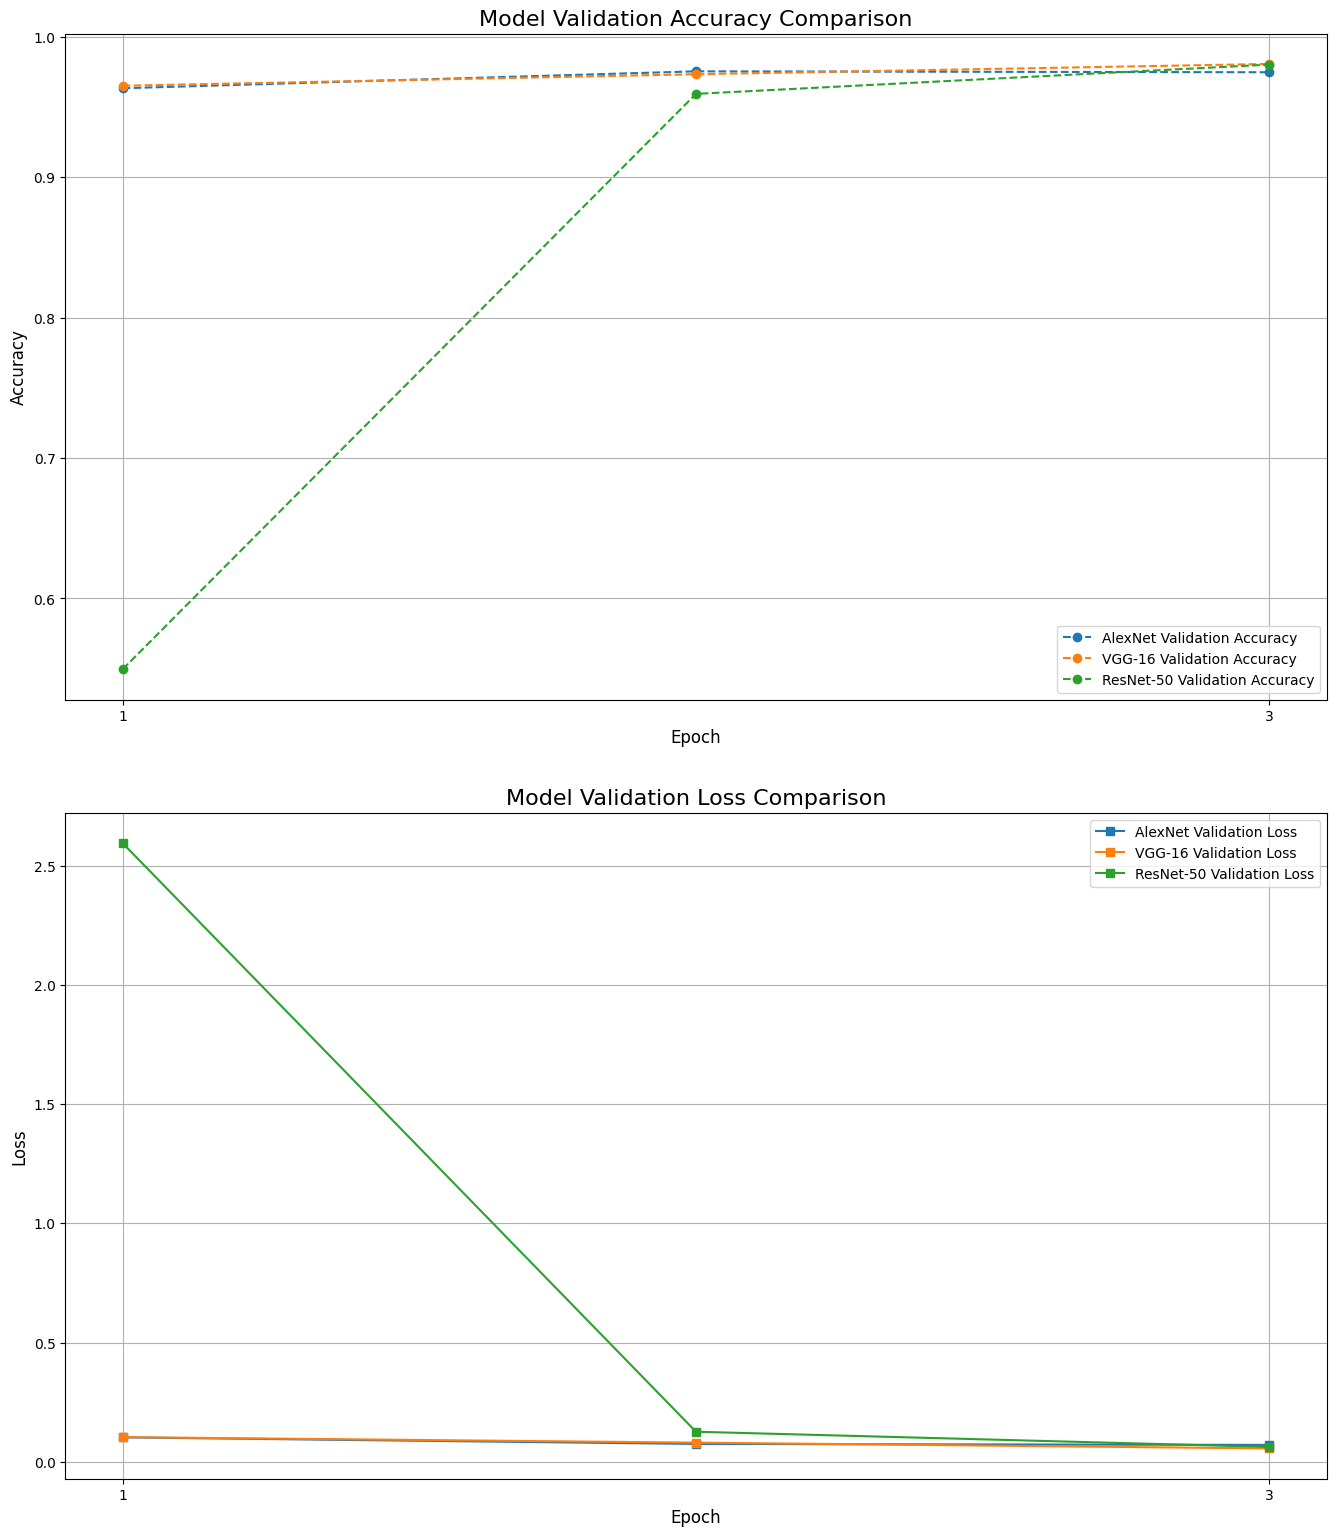

In [ ]:
# --- Compare Validation Accuracy and Loss on Separate Plots ---

# Create a figure with two subplots, arranged vertically (2 rows, 1 column)
# figsize is adjusted to give enough space for two plots.
fig, axes = plt.subplots(2, 1, figsize=(14, 16))

# --- Plot 1: Validation Accuracy ---
ax1 = axes[0] # The first subplot
for name, history in training_histories.items():
    # Get the validation accuracy from the history object
    val_accuracy = history.history['val_accuracy']
    # Plot with markers and a specific line style for clarity
    ax1.plot(val_accuracy, label=f'{name} Validation Accuracy', marker='o', linestyle='--')

ax1.set_title('Model Validation Accuracy Comparison', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True)
# Optional: Improve x-axis ticks to show integer epochs
if training_histories:
    num_epochs = len(next(iter(training_histories.values())).history['val_accuracy'])
    ax1.set_xticks(np.arange(0, num_epochs, 2)) # Show a tick every 2 epochs
    ax1.set_xticklabels(np.arange(1, num_epochs + 1, 2))


# --- Plot 2: Validation Loss ---
ax2 = axes[1] # The second subplot
for name, history in training_histories.items():
    # Get the validation loss from the history object
    val_loss = history.history['val_loss']
    # Plot with different markers and line style
    ax2.plot(val_loss, label=f'{name} Validation Loss', marker='s', linestyle='-')

ax2.set_title('Model Validation Loss Comparison', fontsize=16)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)
# Optional: Improve x-axis ticks for the second plot as well
if training_histories:
    num_epochs = len(next(iter(training_histories.values())).history['val_loss'])
    ax2.set_xticks(np.arange(0, num_epochs, 2))
    ax2.set_xticklabels(np.arange(1, num_epochs + 1, 2))


# Adjust layout automatically to prevent titles/labels from overlapping
plt.tight_layout(pad=3.0)

# Display the final figure with both plots
plt.show()

This code provides a quantitative summary of the results. It iterates through the saved histories and, for each model, finds the single best epoch based on the highest validation accuracy achieved. It then extracts the accuracy, the corresponding loss from that same epoch, and the epoch number. Finally, it uses the pandas library to display this data in a clean, formatted table for easy comparison.

In [ ]:
# Create an empty list to hold the summary data
summary_data = []

# Loop through each history object to find the best performance
for name, history in training_histories.items():
    # Find the epoch with the highest validation accuracy
    val_acc_list = history.history['val_accuracy']
    best_epoch_index = np.argmax(val_acc_list)

    # Get the best validation accuracy value
    best_val_acc = val_acc_list[best_epoch_index]

    # Get the validation loss at the same best epoch
    val_loss_at_best_epoch = history.history['val_loss'][best_epoch_index]

    # Store the results. Add 1 to the index because epochs are 1-based.
    summary_data.append({
        "Model Architecture": name,
        "Best Validation Accuracy": f"{best_val_acc:.4f}",
        "Loss at Best Epoch": f"{val_loss_at_best_epoch:.4f}",
        "Best Epoch": best_epoch_index + 1
    })

# Create a pandas DataFrame for a nice display
df_summary = pd.DataFrame(summary_data)

# Set the model name as the index for better readability
df_summary.set_index("Model Architecture", inplace=True)

# Display the final summary table
print("--- Peak Model Performance Summary ---")
print(df_summary)


--- Peak Model Performance Summary ---
                   Best Validation Accuracy Loss at Best Epoch  Best Epoch
Model Architecture                                                        
AlexNet                              0.9755             0.0749           2
VGG-16                               0.9808             0.0559           3
ResNet-50                            0.9803             0.0622           3


## Final Recomendation

After evaluating the performance of the three models, the Mini-VGG architecture is the recommended final model. Although ResNet-50 achieved a marginally comparable accuracy, the Mini-VGG model provides a superior balance of performance and efficiency. It reached the highest validation accuracy (98.08%) and had the lowest corresponding validation loss (0.0559), all while training significantly faster than the much larger ResNet-50 model. For a practical business application where both high accuracy and rapid deployment are important, the Mini-VGG model offers the most optimal solution.

# Summary of Key Findings and Insights

The modeling exercise yielded several important findings:

- Feature Importance: The decision to downscale the images to 32x32 proved highly effective. The models' ability to achieve >97% accuracy confirms that the core morphological features (shape and size) of the rice grains are the most critical differentiators, and high-resolution textural details are not necessary for this classification task.

- Model Performance: All three adapted CNN architectures performed exceptionally well, demonstrating the suitability of deep learning for this problem. The high accuracies suggest that the classes are visually distinct and can be reliably separated by the models.

- Efficiency vs. Complexity: While the very deep ResNet-50 model performed well, its complexity and long training time did not provide a significant accuracy advantage over the much lighter Mini-VGG model. This highlights that for specific, well-defined problems, a simpler, custom-tailored architecture can be more efficient than a larger, more generic one.

- Rapid Learning: The models were able to achieve near-peak performance within just 3 epochs, indicating that they learned the distinguishing features of the dataset very quickly

# Suggestions for Next Steps

While the current model is highly accurate, several avenues could be explored for further improvement and analysis:

- Transfer Learning: Instead of training the ResNet-50 model from scratch, initialize it with pre-trained weights from the ImageNet dataset (weights='imagenet'). This technique, known as transfer learning, could potentially boost accuracy even further and reduce training time.

- Data Augmentation: To improve model robustness and prevent any potential overfitting if trained for more epochs, data augmentation techniques like random horizontal flips, rotations, and brightness adjustments could be applied to the training set.

- Explore Lightweight Architectures: Test other modern, efficient architectures like MobileNet or EfficientNet. These models are designed to provide high accuracy with very low computational cost, making them ideal for deployment on mobile or edge devices.

- Hyperparameter Tuning: Conduct a more extensive search for optimal hyperparameters, such as experimenting with different learning rates, batch sizes, or optimizer types, to potentially achieve incremental performance gains.

- Deployment: The next logical step for a business application would be to deploy the final recommended model (Mini-VGG) as a web service or API. This would allow it

# @GODER